In [1]:
%matplotlib inline

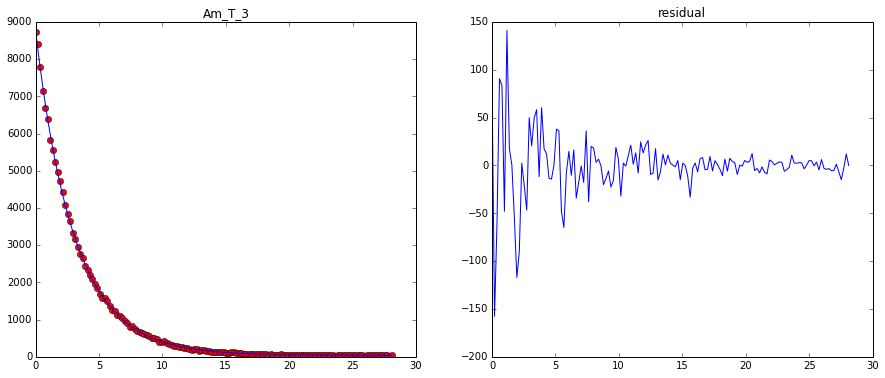

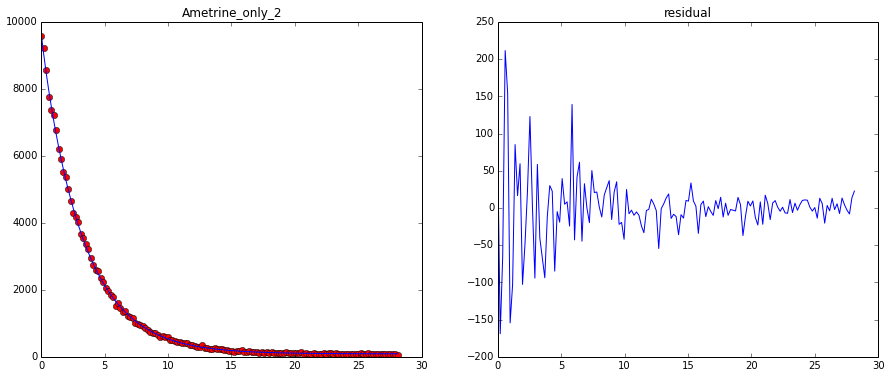

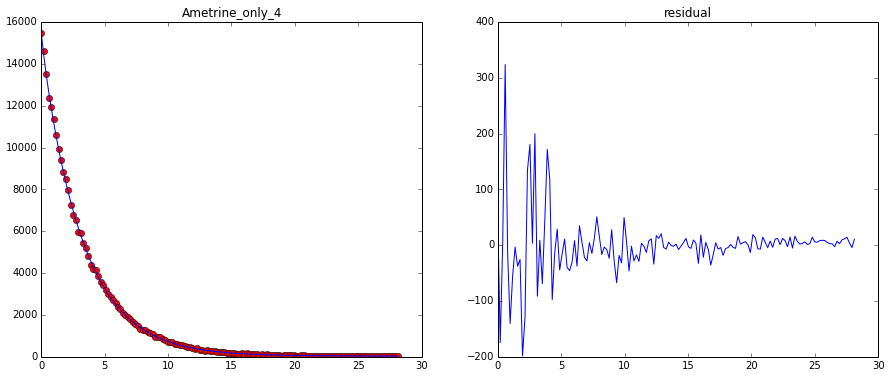

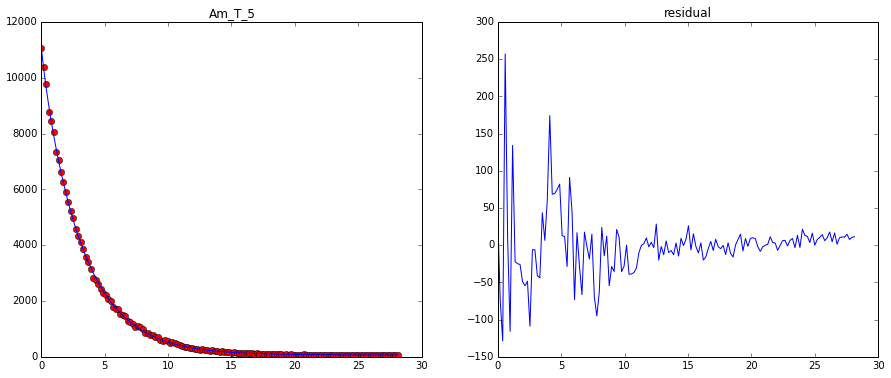

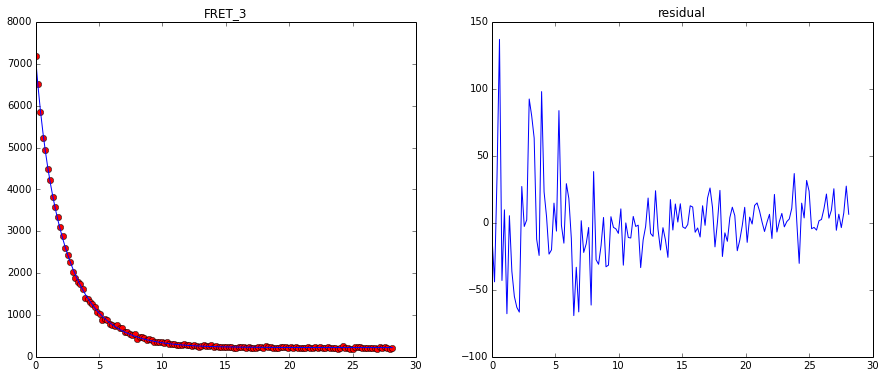

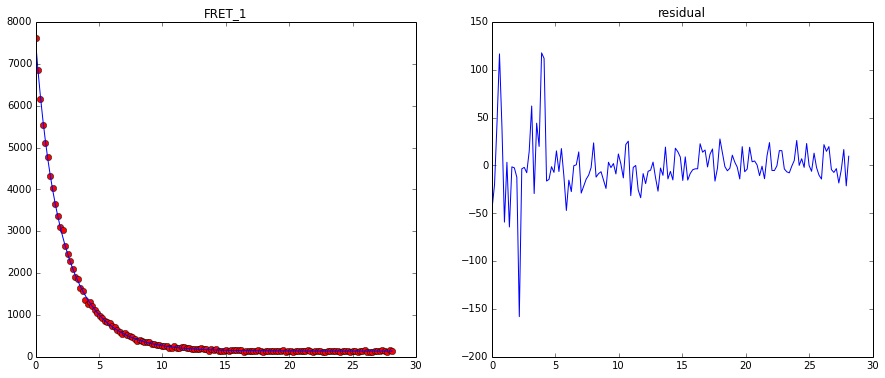

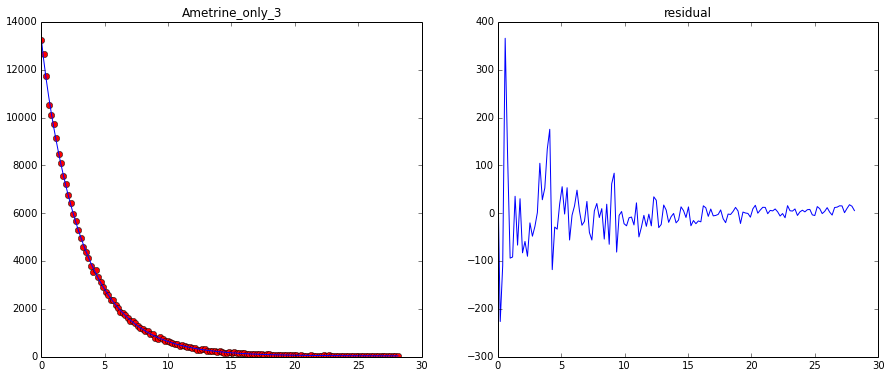

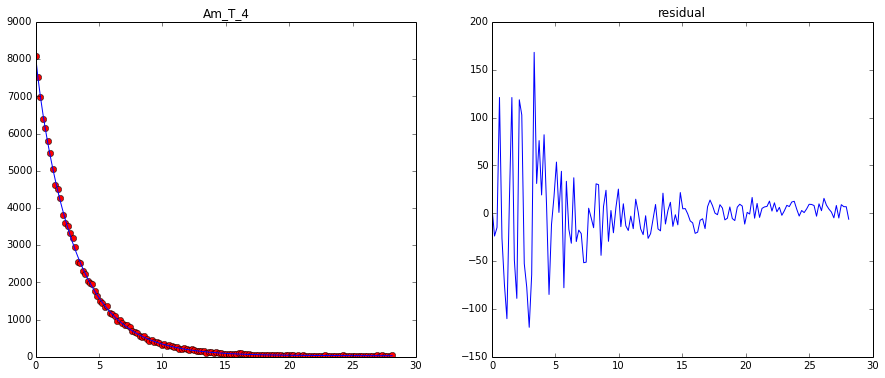

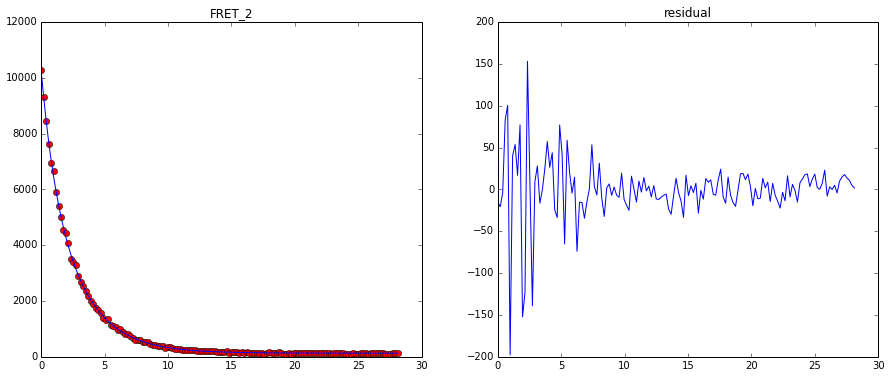

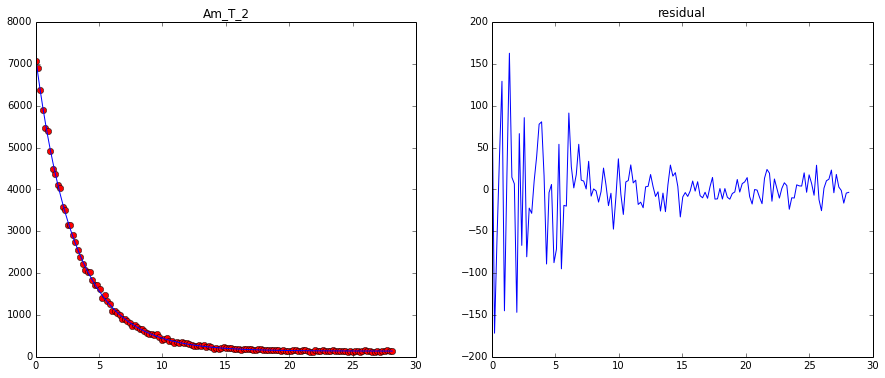

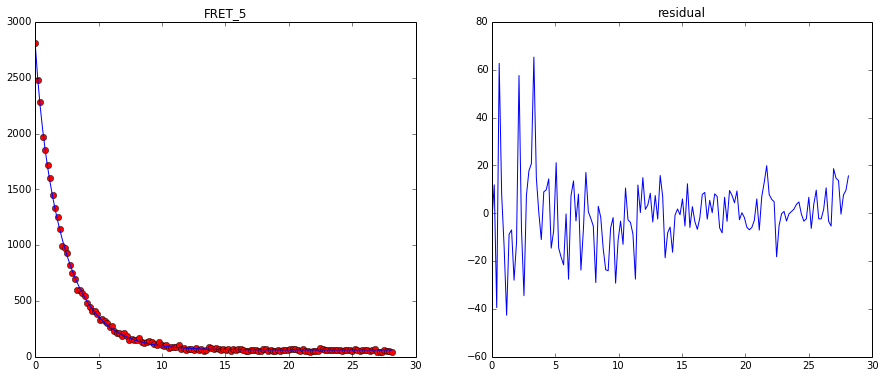

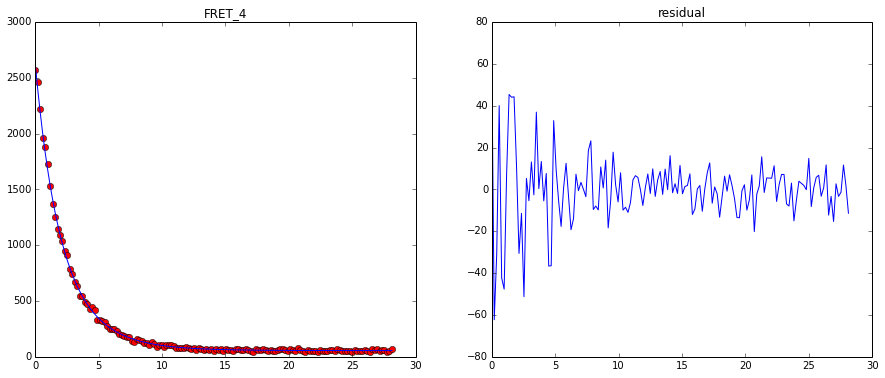

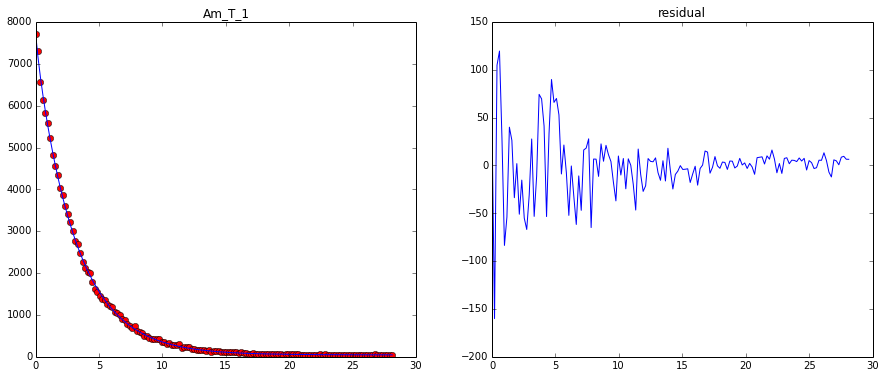

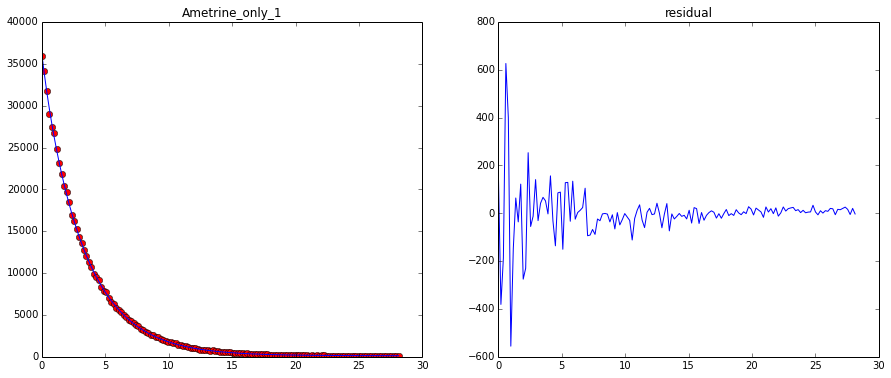

In [10]:
import zipfile
from zipfile import ZipFile
from lxml import etree
from io import StringIO, BytesIO
import numpy as np
from lmfit import minimize, Parameters, Parameter, report_fit
import os
import mahotas
import xlsxwriter
from matplotlib.pyplot import figure, subplot

def get_filepaths(directory):
    """
    This function will generate the file names in a directory 
    tree by walking the tree either top-down or bottom-up. For each 
    directory in the tree rooted at directory top (including top itself), 
    it yields a 3-tuple (dirpath, dirnames, filenames).
    """
    file_paths = []  # List which will store all of the full filepaths.
    filenames = [] # list which stores the corresponding filenames
    # Walk the tree.
    for root, directories, files in os.walk(directory):
        for filename in files:
            # Join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)  # Add it to the list.
            filenames.append(filename)  # Add it to the list.

    return file_paths,filenames  # Self-explanatory.

# Run the above function and store its results in a variable.   
full_file_paths,full_file_names = get_filepaths("/home/amarb/Work/FLIMTD data/")
results_dict={}

workbook   = xlsxwriter.Workbook('FLIM_raw_dat.xlsx')
for f in full_file_paths:

  if f.endswith(".iss-tdflim"):
   
    #print f
    head,tail=os.path.split(f)
    f_name_only,f_ext=os.path.splitext(tail)
    #print f_name_only
    fpath_to_open='/home/amarb/Work/FLIMTD data/%s.iss-tdflim' % f_name_only

    #zip_f_hndl = ZipFile(fpath_to_open)
    #path_to_extract='/home/amarb/Work/FLIMTD data/%s_dir/' % f_name_only
    #zip_f_hndl.extractall(path_to_extract)
    
    tree=etree.parse('/home/amarb/Work/FLIMTD data/%s_dir/dataProps/Core.xml' % f_name_only)
    docinfo=tree.docinfo
    root=tree.getroot()

    for items in root.iter("Dimensions"):
        for items1 in items.iter("FrameWidth"):frame_pix_width=int(items1.text)
        for items1 in items.iter("FrameHeight"):frame_pix_height=int(items1.text)
        for items1 in items.iter("FrameCount"):num_frames=int(items1.text)
    for items in root.iter("PhotonCountingSettings"):
        for items1 in items.iter("AdcResolution"):adc_res=int(items1.text)
        
    dataf=open('/home/amarb/Work/FLIMTD data/%s_dir/data/PrimaryDecayData.bin' % f_name_only)
    decay_dat_1=np.fromfile(dataf,dtype='uint16',count=67108864)
    decay_dat_2=np.fromfile(dataf,dtype='uint16',count=67108864)
    dataf.close()
    #decay_dat_1=numpy.reshape(decay_dat_1,(frame_pix_width,frame_pix_height,adc_res),order='C')
    decay_dat_2=numpy.reshape(decay_dat_2,(frame_pix_width,frame_pix_height,adc_res),order='C')
    #decay_dat_sim_1=numpy.sum(decay_dat_1,axis=2)
    decay_dat_sim_2=numpy.sum(decay_dat_2,axis=2)
        
    T_otsu = mahotas.thresholding.otsu(decay_dat_sim_2)
    bin_dat=decay_dat_sim_2>T_otsu
    bin_dat=np.reshape(bin_dat,(frame_pix_width,frame_pix_height,1))
    mask_dat=np.tile(bin_dat,(1,1,adc_res))
    mask_dat.shape
    
    #subplot(1,2,1)
    #imshow(new_dat)
    #subplot(1,2,2)
    #imshow(decay_dat_sim_2)
    
    #tau_mat=np.zeros((128,128,5))
    #tau_mat=np.zeros((128,128,3))

    def func_to_min(params,x,data):
        amp1 = params['amp1'].value
        amp2 = params['amp2'].value
        tau1 = params['tau1'].value
        tau2 = params['tau2'].value
        offset=params['offset'].value
        model = amp1*np.exp(-x/tau1)+amp2*np.exp(-x/tau2) + offset
        return model-data
    
    params=Parameters()
    params.add('amp1', value=5000,min=0,vary=True)
    params.add('amp2', value=5000, min=0,vary=True)
    params.add('tau1', value=3, min=0.1,vary=True)
    params.add('tau2', value=8, min=0.1,vary=True)
    params.add('offset', value=1, min=0,vary=True)

    x = np.arange(0,145)*50.0/256.0
    decay_dat_2_masked=np.multiply(decay_dat_2,mask_dat)
    decay_dat_sim_2=np.sum(decay_dat_2_masked[:,:,55:200],axis=(0,1))
    result=minimize(func_to_min,params,args=(x,decay_dat_sim_2))
    worksheet = workbook.add_worksheet(f_name_only)
    worksheet.write('B2', 'Time')
    worksheet.write_column('B3', x)
    worksheet.write('C2', 'Counts_raw')
    worksheet.write_column('C3', decay_dat_sim_2)
    worksheet.write('D2', 'Fit_curve')
    worksheet.write_column('D3', decay_dat_sim_2+result.residual)
    worksheet.write('E2', 'Residuals')
    worksheet.write_column('E3', result.residual)
    figure(figsize(15,6))
    subplot(1,2,1)
    plot(x,decay_dat_sim_2,'ro')
    plot(x,decay_dat_sim_2+result.residual)
    plt.title(f_name_only)
    subplot(1,2,2)
    plot(x,result.residual)
    plt.title('residual')
    savefig('/home/amarb/Work/FLIMTD data/%s_graph.png' % f_name_only, bbox_inches='tight')
    results_dict[f_name_only]=(params['amp1'].value, params['tau1'].value,params['amp2'].value, params['tau2'].value)
workbook.close()

In [76]:
results_dict

{'Am_T_1': (257.71060419575906,
  0.25063893008637084,
  7442.3875711920409,
  3.1448196541485163),
 'Am_T_2': (354.43491313246568,
  1.2299644249713353,
  6690.3447689257,
  3.2532312507229251),
 'Am_T_3': (625.86653624042856,
  1.3617306791563402,
  8141.1231111448433,
  3.2158022398747037),
 'Am_T_4': (283.19415664096249,
  0.31159048580432891,
  7792.5025475584234,
  3.1090111901250315),
 'Am_T_5': (345.0952265193294,
  0.33855490214817541,
  10708.319129491496,
  3.1774513962490967),
 'Ametrine_only_1': (1138.4530197127501,
  0.50578630053370877,
  34879.99971899599,
  3.2784397778905316),
 'Ametrine_only_2': (178.1971783980519,
  0.390532049199945,
  9388.1676342664541,
  3.283561838396984),
 'Ametrine_only_3': (381.43940491448421,
  0.34837254958373276,
  12915.907871002235,
  3.2591831866063159),
 'Ametrine_only_4': (386.421422285841,
  0.27841136525865851,
  15093.395558424469,
  3.2518740353170172),
 'FRET_1': (1605.8222548929489,
  0.93070670223116603,
  5823.5633216863125,


3